## Environment check

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.9.1+cu128
False


imports & global config (skeleton)

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets,transforms

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Reproducibility

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

train_size = int(0.9*len(train_dataset))
val_size = len(train_dataset)-train_size

train_dataset,val_dataset = torch.utils.data.random_split(
    train_dataset,[train_size,val_size]
)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)


In [5]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28,256)
        self.fc2=nn.Linear(256,128)
        self.fc3=nn.Linear(128,64)
        self.fc4=nn.Linear(64,10)
    def forward(self, x):
        x=x.view(x.size(0),-1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=self.fc4(x)
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)

print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


In [7]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3
)

In [8]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

In [9]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs,labels)

            running_loss += loss.item()*images.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds==labels).sum().item()
    epoch_loss = running_loss / len(loader.dataset)
    accuracy = correct/len(loader.dataset)

    return epoch_loss,accuracy

In [10]:
num_epochs = 10

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        model,train_loader,optimizer,criterion,device
    )
    val_loss,val_acc = evaluate(
        model,val_loader, criterion,device
    )
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} "
        f"Val Loss: {val_loss:.4f} "
        f"Val Acc: {val_acc:.4f}"
    )  


Epoch [1/10] Train Loss: 0.4097 Val Loss: 0.1957 Val Acc: 0.9458
Epoch [2/10] Train Loss: 0.1483 Val Loss: 0.1506 Val Acc: 0.9530
Epoch [3/10] Train Loss: 0.1001 Val Loss: 0.1103 Val Acc: 0.9672
Epoch [4/10] Train Loss: 0.0735 Val Loss: 0.1066 Val Acc: 0.9693
Epoch [5/10] Train Loss: 0.0556 Val Loss: 0.1067 Val Acc: 0.9712
Epoch [6/10] Train Loss: 0.0450 Val Loss: 0.0984 Val Acc: 0.9713
Epoch [7/10] Train Loss: 0.0344 Val Loss: 0.0933 Val Acc: 0.9740
Epoch [8/10] Train Loss: 0.0289 Val Loss: 0.0918 Val Acc: 0.9730
Epoch [9/10] Train Loss: 0.0213 Val Loss: 0.0876 Val Acc: 0.9743
Epoch [10/10] Train Loss: 0.0199 Val Loss: 0.1081 Val Acc: 0.9720


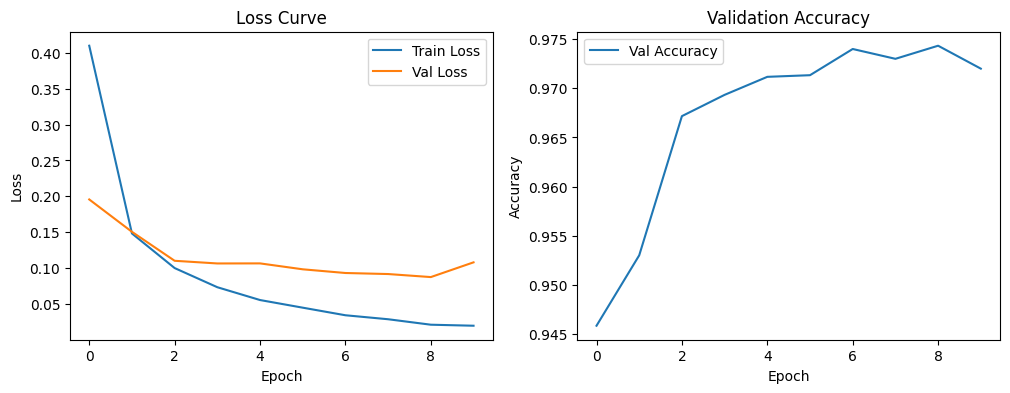

In [11]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.show()


In [12]:
look_in = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

In [13]:
print(look_in)

In [14]:
for images, labels in look_in:
    a=images[0][0]
    b=labels[0]
    break
print(images.shape)
print(labels.shape)
print(a.shape)
print(b.shape)
print(images.view(images.size(0),-1).shape)
print(type(images))

torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([28, 28])
torch.Size([])
torch.Size([128, 784])
<class 'torch.Tensor'>


In [15]:
train_play=DataLoader(dataset=train_dataset,batch_size=64,shuffle=True)

In [16]:
for i,l in train_play:
    print(l)
    break

tensor([7, 4, 6, 7, 6, 3, 5, 9, 6, 6, 1, 9, 9, 5, 8, 7, 1, 3, 5, 0, 8, 2, 8, 3,
        1, 6, 2, 5, 7, 9, 4, 9, 6, 5, 0, 6, 4, 5, 6, 6, 7, 2, 3, 6, 9, 4, 1, 0,
        1, 8, 7, 1, 0, 8, 3, 6, 2, 1, 1, 2, 3, 9, 9, 3])


In [17]:
counterr=0
for i,l in train_play:
    counterr+=1
print(counterr)

844


In [18]:
type(train_dataset[0])

tuple

In [19]:
train_dataset[0][1]

6

In [20]:
op1=model(train_dataset[0][0])

In [21]:
print(len(op1[0]))

10


In [22]:
for i in range(len(op1[0])):
    print(i,op1[0][i])

0 tensor(-0.2244, grad_fn=<SelectBackward0>)
1 tensor(-11.6607, grad_fn=<SelectBackward0>)
2 tensor(-3.9036, grad_fn=<SelectBackward0>)
3 tensor(-4.1202, grad_fn=<SelectBackward0>)
4 tensor(-7.7831, grad_fn=<SelectBackward0>)
5 tensor(-0.7515, grad_fn=<SelectBackward0>)
6 tensor(8.5232, grad_fn=<SelectBackward0>)
7 tensor(-20.9270, grad_fn=<SelectBackward0>)
8 tensor(1.4823, grad_fn=<SelectBackward0>)
9 tensor(-5.6136, grad_fn=<SelectBackward0>)


In [23]:
answer = 6
t_answer = torch.tensor(answer,dtype=torch.long)
print(t_answer)
t_answer=t_answer.unsqueeze(0)
print(t_answer)

tensor(6)
tensor([6])


In [24]:
loss1=criterion(op1,t_answer)

In [25]:
print(loss1)

tensor(0.0011, grad_fn=<NllLossBackward0>)


In [26]:
optimizer.zero_grad()

In [27]:
print(loss1.backward())

None


In [28]:
optimizer.step()

## Test Evaluation

In [29]:
def evaluate_on_test(model, loader, device):
    model.eval()
    correct=0
    all_preds=[]
    all_labels=[]
    with torch.no_grad():
        for images,labels in loader:
            images=images.to(device)
            labels=labels.to(device)

            outputs=model(images)

            preds=outputs.argmax(dim=1)

            correct+=(preds==labels).sum().item()

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    accuracy=correct/len(loader.dataset)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return accuracy,all_preds,all_labels

In [30]:
test_acc,test_preds,test_labels = evaluate_on_test(
    model,test_loader,device
)

print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9731


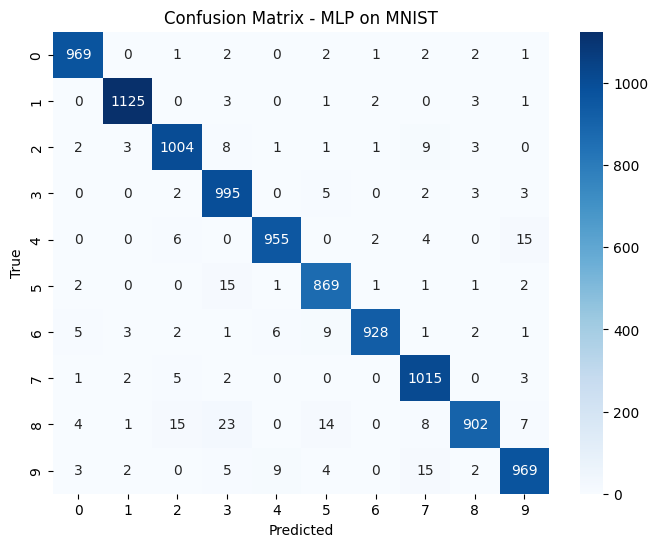

In [31]:
cm = confusion_matrix(test_labels,test_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLP on MNIST")
plt.show()

## A Controlled experiment 
change learning rate

In [38]:
def init_mlp():
    set_seed(42)
    model = MLP().to(device)
    return model

In [39]:
model_lr_small = init_mlp()

optimizer_small=torch.optim.Adam(
    params=model_lr_small.parameters(),
    lr=1e-4
)

train_losses_lr=[]
val_acc_lr=[]
for epoch in range(15):
    train_loss = train_one_epoch(
        model_lr_small,train_loader,
        optimizer_small,criterion,device
    )
    _,val_acc = evaluate(
        model_lr_small,train_loader,criterion,device
    )
    train_losses_lr.append(train_loss)
    val_acc_lr.append(val_acc)
    print(
        f"Epoch {epoch+1} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )


Epoch 1 | Train Loss: 1.1400 | Val Acc: 0.8714
Epoch 2 | Train Loss: 0.3922 | Val Acc: 0.9022
Epoch 3 | Train Loss: 0.3145 | Val Acc: 0.9178
Epoch 4 | Train Loss: 0.2708 | Val Acc: 0.9288
Epoch 5 | Train Loss: 0.2396 | Val Acc: 0.9358
Epoch 6 | Train Loss: 0.2142 | Val Acc: 0.9432
Epoch 7 | Train Loss: 0.1930 | Val Acc: 0.9481
Epoch 8 | Train Loss: 0.1760 | Val Acc: 0.9534
Epoch 9 | Train Loss: 0.1604 | Val Acc: 0.9566
Epoch 10 | Train Loss: 0.1477 | Val Acc: 0.9604
Epoch 11 | Train Loss: 0.1372 | Val Acc: 0.9624
Epoch 12 | Train Loss: 0.1263 | Val Acc: 0.9652
Epoch 13 | Train Loss: 0.1184 | Val Acc: 0.9682
Epoch 14 | Train Loss: 0.1106 | Val Acc: 0.9699
Epoch 15 | Train Loss: 0.1042 | Val Acc: 0.9711


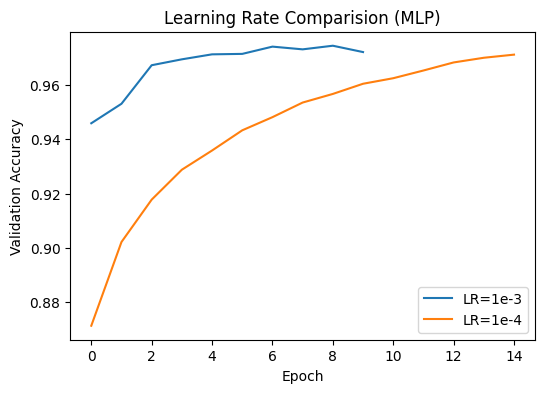

In [40]:
plt.figure(figsize=(6,4))
plt.plot(val_accuracies,label="LR=1e-3")
plt.plot(val_acc_lr,label="LR=1e-4")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.title("Learning Rate Comparision (MLP)")
plt.show()

In [48]:
class MLPWithDropout(nn.Module):
    def __init__(self,p=0.5):
        super().__init__()
        self.fc1=nn.Linear(28*28,256)
        self.fc2=nn.Linear(256,128)
        self.fc3=nn.Linear(128,10)
        self.dropout = nn.Dropout(p)
    def forward(self,x):
        x=x.view(x.size(0),-1)
        x=F.relu(self.fc1(x))
        x=self.dropout(x)
        x=F.relu(self.fc2(x))
        x=self.dropout(x)
        x=self.fc3(x)
        return x



In [49]:
set_seed(42)
model_dropout=MLPWithDropout(p=0.5).to(device)

optimizer_dropout=torch.optim.Adam(
    params=model_dropout.parameters(),lr=1e-3
)

train_losses_do=[]
val_acc_do=[]

for epoch in range(num_epochs):
    train_loss=train_one_epoch(
        model_dropout,train_loader,
        optimizer_dropout,criterion,device
    )
    _, val_acc = evaluate(
        model_dropout, val_loader, criterion, device
    )

    train_losses_do.append(train_loss)
    val_acc_do.append(val_acc)

    print(
            f"Epoch {epoch+1} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Acc: {val_acc:.4f}"
    )


Epoch 1 | Train Loss: 0.5410 | Val Acc: 0.9315
Epoch 2 | Train Loss: 0.2445 | Val Acc: 0.9540
Epoch 3 | Train Loss: 0.1919 | Val Acc: 0.9640
Epoch 4 | Train Loss: 0.1661 | Val Acc: 0.9663
Epoch 5 | Train Loss: 0.1465 | Val Acc: 0.9692
Epoch 6 | Train Loss: 0.1322 | Val Acc: 0.9683
Epoch 7 | Train Loss: 0.1218 | Val Acc: 0.9713
Epoch 8 | Train Loss: 0.1154 | Val Acc: 0.9723
Epoch 9 | Train Loss: 0.1092 | Val Acc: 0.9727
Epoch 10 | Train Loss: 0.1024 | Val Acc: 0.9763


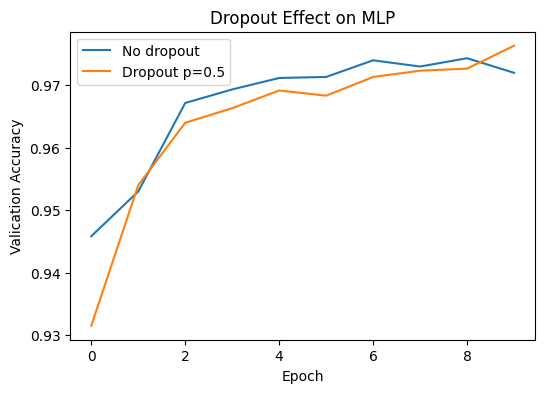

In [50]:
plt.figure(figsize=(6,4))
plt.plot(val_accuracies, label="No dropout")
plt.plot(val_acc_do,label="Dropout p=0.5")
plt.xlabel("Epoch")
plt.ylabel("Valication Accuracy")
plt.legend()
plt.title("Dropout Effect on MLP")
plt.show()


In [47]:
print(val_acc_do)

[0.9736666666666667]
